In [81]:
import pandas as pd
import os
import numpy as np
import itertools
from sklearn.metrics import r2_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve, mean_absolute_error
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:

def plot_confusion_matrix(
    working_dir, cm, target_names, title="Confusion matrix", cmap=None, normalize=False
):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(9, 8))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                f"{cm[i, j]:0.4f}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]:,}",
                horizontalalignment="center",
                color="black",
                # color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel(f"Predicted label\naccuracy={accuracy:0.4f}; misclass={misclass:0.4f}")

    plt.savefig(os.path.join(working_dir, title + ".pdf"))
    plt.savefig(os.path.join(working_dir, title + ".png"))
    plt.clf()


def print_classification_report(y_true, y_pred):
    """
    Prints classification report to stdout.

    Args:
        y_true (nparray): 1D npy array containing int values for class
        y_pred (nparray): 1D npy array containing int values for predicted class
        train_gen (Keras Generator): Training generator used for model training, used for labels
    """
    print("Classification Report")
    print(classification_report(y_true, y_pred))



In [5]:
df = pd.read_csv("AFT_Timesweeper_res.csv")
lab_dict = {0: "neut", 1: "sdn", 2: "ssv"}
dict_lab = {v:k for k,v in lab_dict.items()}
df["pred_str"] = [lab_dict[i] for i in df["pred_sweep"]] 
df["true_num"] = [dict_lab[i] for i in df["sweep"]]
df.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,pred_str,true_num
0,0,neut,0,0.900236,0.031182,0.068582,0.0,0.023495,0.157943,neut,0
1,1,neut,0,0.967756,0.018013,0.014232,0.0,0.023938,0.048872,neut,0
2,10,neut,0,0.944564,0.026852,0.028584,0.0,0.023861,0.115227,neut,0
3,100,neut,0,0.914856,0.037577,0.047567,0.0,0.018109,0.073310,neut,0
4,1001,neut,0,0.893581,0.014559,0.091860,0.0,0.025733,0.068648,neut,0


In [84]:
print_classification_report(df["sweep"], df["pred_str"])
plot_confusion_matrix('.', confusion_matrix(df["sweep"], df["pred_str"]), list(lab_dict.values()), normalize=True, title="Timesweeper Test Data")


Classification Report
              precision    recall  f1-score   support

        neut       0.79      0.94      0.86      5046
         sdn       0.63      0.85      0.72      5047
         ssv       0.80      0.36      0.50      5026

    accuracy                           0.72     15119
   macro avg       0.74      0.72      0.69     15119
weighted avg       0.74      0.72      0.69     15119



<Figure size 648x576 with 0 Axes>

Classification Report
              precision    recall  f1-score   support

        neut       0.80      0.93      0.86      5046
         sdn       0.63      0.85      0.72      5047
         ssv       0.78      0.38      0.51      5026

    accuracy                           0.72     15119
   macro avg       0.73      0.72      0.70     15119
weighted avg       0.73      0.72      0.70     15119



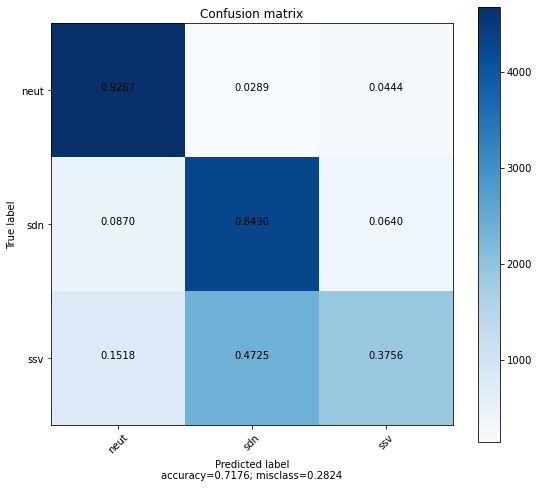

In [77]:
testdf = df.copy()
testdf.head()

testdf.loc[(testdf["pred_str"] == "neut") & (testdf["ssv_prob"] > 0.4), "pred_str"] = "ssv"
testdf
print_classification_report(testdf["sweep"], testdf["pred_str"])
plot_confusion_matrix('.', confusion_matrix(testdf["sweep"], testdf["pred_str"]), list(lab_dict.values()), normalize=True)


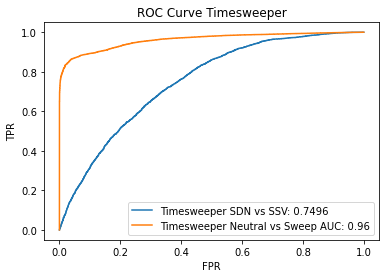

<Figure size 432x288 with 0 Axes>

In [76]:
"""Plot ROC curve by binarizing neutral/sweep."""

# Plot sdn/ssv distinction
sweep_idxs = np.transpose(np.array((df["true_num"] > 0)).nonzero())
sweep_labs = np.array(df["true_num"])[sweep_idxs]

sdn_probs = df[df["true_num"] > 0]["sdn_prob"]

swp_fpr, swp_tpr, thresh = roc_curve(sweep_labs, sdn_probs, pos_label=1)
swp_auc_val = auc(swp_fpr, swp_tpr)
plt.plot(
    swp_fpr,
    swp_tpr,
    label=f"Timesweeper SDN vs SSV: {swp_auc_val:.4}",
)

# Coerce all ssvs into sweep binary pred
labs = np.array(df["true_num"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([df["sdn_prob"], df["ssv_prob"]]).T, axis=1)

# Plot ROC Curve
fpr, tpr, thresh = roc_curve(labs, pred_probs)
auc_val = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"Timesweeper Neutral vs Sweep AUC: {auc_val:.2}")

plt.title(f"ROC Curve Timesweeper")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

plt.show()
plt.savefig("ts_roc.png")

Text(0, 0.5, 'Precision')

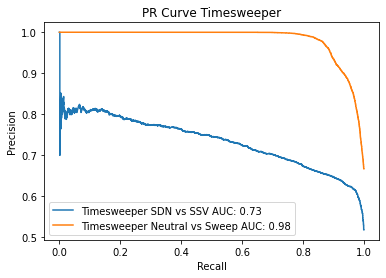

In [9]:
name="Timesweeper"
"""Plot PR curve by binarizing neutral/sweep."""
# Plot sdn/ssv distinction

filt_df = df[(df["sdn_prob"] > 0.0) & (df["ssv_prob"] > 0.0)]

sweep_idxs = np.transpose(np.array((filt_df["true_num"] > 0)).nonzero())
sweep_labs = np.array(filt_df["true_num"])[sweep_idxs]

sweep_labs[sweep_labs == 1] = 1
sweep_labs[sweep_labs == 2] = 0

if len(np.unique(filt_df["true_num"])) > 2:
    sdn_probs = filt_df[filt_df["true_num"] > 0]["sdn_prob"] / (
        filt_df[filt_df["true_num"] > 0]["sdn_prob"]
        + filt_df[filt_df["true_num"] > 0]["ssv_prob"]
    )

    swp_prec, swp_rec, swp_thresh = precision_recall_curve(
        sweep_labs.flatten(), sdn_probs
    )
    swp_auc_val = auc(swp_rec, swp_prec)
    plt.plot(
        swp_rec,
        swp_prec,
        label=f"{name.capitalize()} SDN vs SSV AUC: {swp_auc_val:.2}",
    )

# Coerce all ssvs into sweep binary pred
labs = np.array(df["true_num"])
labs[labs > 1] = 1
pred_probs = np.sum(np.array([df["sdn_prob"], df["ssv_prob"]]).T, axis=1)

# Plot PR Curve for binarized labs
prec, rec, thresh = precision_recall_curve(labs, pred_probs)
auc_val = auc(rec, prec)
plt.plot(rec, prec, label=f"{name.capitalize()} Neutral vs Sweep AUC: {auc_val:.2}")

plt.title(f"PR Curve {name}")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

In [10]:
df.head()

,rep,sweep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,pred_str,true_num
0,0,neut,0,0.900236,0.031182,0.068582,0.0,0.023495,0.157943,neut,0
1,1,neut,0,0.967756,0.018013,0.014232,0.0,0.023938,0.048872,neut,0
2,10,neut,0,0.944564,0.026852,0.028584,0.0,0.023861,0.115227,neut,0
3,100,neut,0,0.914856,0.037577,0.047567,0.0,0.018109,0.073310,neut,0
4,1001,neut,0,0.893581,0.014559,0.091860,0.0,0.025733,0.068648,neut,0


In [11]:
df[df["sweep"] == "ssv"].describe()

,rep,pred_sweep,neut_prob,sdn_prob,ssv_prob,s_val,sdn_sval,ssv_sval,true_num
count,5026.000000,5026.000000,5.026000e+03,5026.000000,5026.000000,5026.000000,5026.000000,5026.000000,5026.0
mean,2525.876840,1.191206,1.425045e-01,0.381885,0.475611,0.125607,0.125777,0.123206,2.0
std,1458.178518,0.700711,2.679289e-01,0.264320,0.229687,0.071217,0.066860,0.060587,0.0
min,0.000000,0.000000,2.662731e-07,0.001160,0.010885,0.000261,0.013317,-0.000696,2.0
25%,1263.250000,1.000000,1.082701e-04,0.106912,0.321421,0.064006,0.065501,0.066333,2.0
50%,2523.500000,1.000000,1.528072e-03,0.440195,0.405083,0.126490,0.133581,0.129543,2.0
75%,3788.750000,2.000000,1.064246e-01,0.631234,0.664755,0.186302,0.189001,0.178070,2.0
max,5050.000000,2.000000,9.696735e-01,0.820960,0.972225,0.249961,0.241946,0.243675,2.0


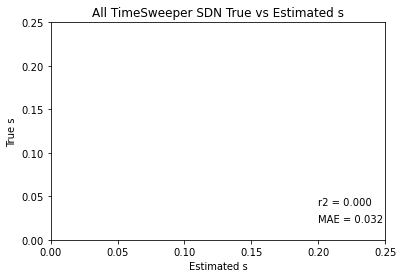

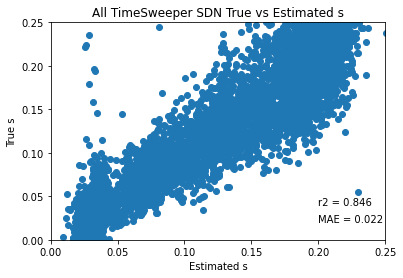

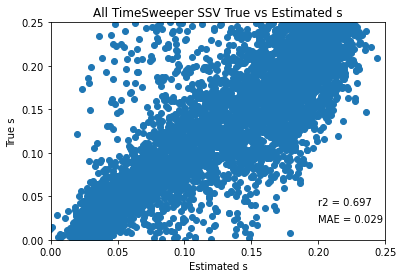

<Figure size 432x288 with 0 Axes>

In [12]:
for swp in df["sweep"].unique():
    subdf = df[df["sweep"] == swp].dropna()
    if swp == "neut":
        swp = "sdn"
    else:
        plt.scatter(x=subdf[f"{swp}_sval"], y=subdf["s_val"])
        
    plt.xlim(0, .25)
    plt.ylim(0, .25)
    plt.annotate("r2 = {:.3f}".format(r2_score(subdf["s_val"], subdf[f"{swp}_sval"])), (0.20, 0.04))
    plt.annotate("MAE = {:.3f}".format(mean_absolute_error(subdf["s_val"], subdf[f"{swp}_sval"])), (0.20, 0.02))
    plt.title(f"All TimeSweeper {swp.upper()} True vs Estimated s") 
    plt.xlabel("Estimated s") 
    plt.ylabel("True s") 
    plt.savefig(f"{swp}_true_v_est_ts.pdf")
    plt.show()
    plt.clf()

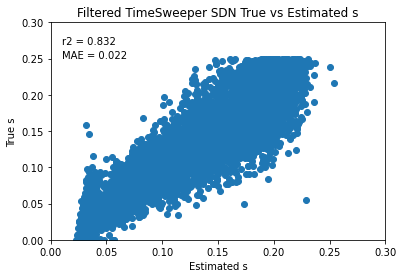

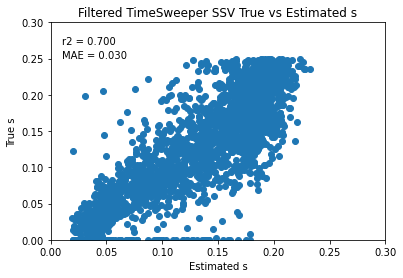

<Figure size 432x288 with 0 Axes>

In [13]:
for swp in df["sweep"].unique():
    subdf = df[df["pred_str"] == swp].dropna()
    if swp == "neut":
        continue
    else:
        plt.scatter(x=subdf[f"{swp}_sval"], y=subdf["s_val"])
        
    plt.xlim(0, .3)
    plt.ylim(0, .3)
    plt.annotate("r2 = {:.3f}".format(r2_score(subdf["s_val"], subdf[f"{swp}_sval"])), (0.01, 0.27))
    plt.annotate("MAE = {:.3f}".format(mean_absolute_error(subdf["s_val"], subdf[f"{swp}_sval"])), (0.01, 0.25))
    plt.title(f"Filtered TimeSweeper {swp.upper()} True vs Estimated s") 
    plt.xlabel("Estimated s") 
    plt.ylabel("True s") 
    plt.savefig(f"{swp}_true_v_est_ts.pdf")
    plt.show()
    plt.clf()

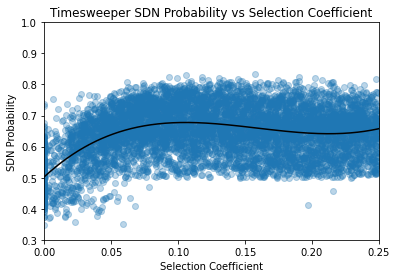

In [65]:
swp = "sdn"
subdf = df[df["pred_str"] == swp].dropna()

plt.scatter(x=subdf[f"s_val"], y=subdf["sdn_prob"], alpha=0.3)

z = np.polyfit(subdf['s_val'], subdf["sdn_prob"], 3)
p = np.poly1d(z)
plt.plot(sorted(subdf["s_val"]), p(sorted(subdf["s_val"])), color="black", lw=1.5)

plt.xlim(0, .25)
plt.ylim(.3, 1.)
plt.title(f"Timesweeper SDN Probability vs Selection Coefficient") 
plt.xlabel("Selection Coefficient") 
plt.ylabel("SDN Probability") 
plt.savefig(f"{swp}_prob_vs_selcoeff.pdf")
plt.show()


In [15]:
test_df = pd.read_csv("/work/users/l/s/lswhiteh/timesweeper-experiments/simple_sims/better_benchmark/test_benchmark/Test_Benchmark_params.tsv", header=0, sep="\t")
test_df.head()
test_df = test_df[test_df["sweep"] == "ssv"]

In [16]:
freq_changes = []
for row in test_df.loc[:, "selAlleleFreq"]:
    freqs = [float(i) for i in row.strip('][').split(', ')]
    freq_changes.append(freqs[-1] - freqs[0])

In [22]:
np.stack((test_df["selCoeff"], freq_changes))

array([[0.01422178, 0.17442176, 0.09339638, ..., 0.08129648, 0.04591919,
        0.08377927],
       [0.008     , 0.        , 0.886     , ..., 0.        , 0.878     ,
        0.        ]])

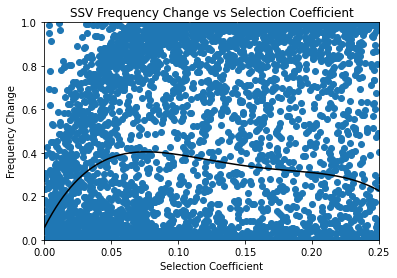

In [75]:
plt.scatter(test_df["selCoeff"], freq_changes)

plt.xlim(0, 0.25)
plt.ylim(0, 1.)

z = np.polyfit(test_df["selCoeff"], freq_changes, 4)
p = np.poly1d(z)
plt.plot(sorted(test_df["selCoeff"]), p(sorted(test_df["selCoeff"])), color="black", lw=1.5)

plt.title(f"SDN Frequency Change vs Selection Coefficient") 
plt.xlabel("Selection Coefficient") 
plt.ylabel("Frequency Change") 
plt.savefig(f"sdn_freqs_vs_selcoeff.pdf")
plt.show()